<center><h1>DSCI-552 Final Project</h1></center>

<ul>
    Name : <b>Pavan Kumar R</b><br>
    Github Username : <b>pavan-r411</b><br>
    USC Id : <b>6159315758</b>
</ul>

In [1]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
from tensorflow.keras.applications import ResNet50, ResNet101, VGG16, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

<b><h3>Transfer Learning for Image Classification</h3></b>

In [2]:
model_test_results = {}
model_cv_results = {}

In [3]:
DATASET_PATH = "../data/RealWaste/" 
IMG_SIZE = (299, 299)
SEED = 42

random.seed(SEED)
class_names = sorted(os.listdir(DATASET_PATH))
num_classes = len(class_names)

X_train, y_train = [], []
X_test, y_test = [], []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_PATH, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = sorted(os.listdir(class_dir))
    total = len(images)
    train_count = int(0.8 * total)
    
    train_files = images[:train_count]
    test_files = images[train_count:]

    def load_images(file_list):
        data = []
        for file in file_list:
            path = os.path.join(class_dir, file)
            img = cv2.imread(path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                data.append(img)
        return data

    X_train.extend(load_images(train_files))
    y_train.extend([class_idx] * len(train_files))

    X_test.extend(load_images(test_files))
    y_test.extend([class_idx] * len(test_files))

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(" Done!")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

 Done!
X_train: (3798, 299, 299, 3) y_train: (3798, 9)
X_test: (954, 299, 299, 3) y_test: (954, 9)


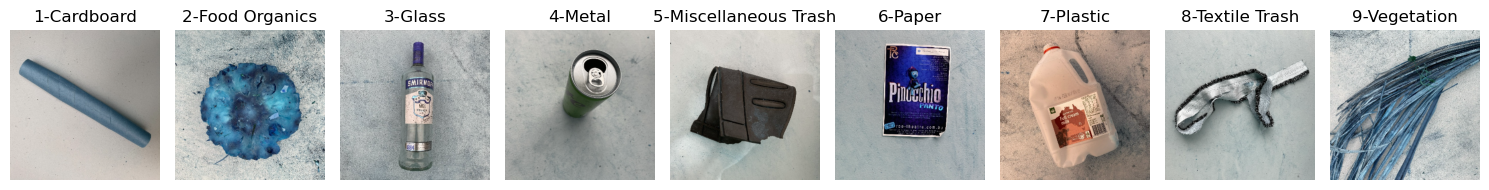

In [4]:
y_labels = np.argmax(y_train, axis=1)

plt.figure(figsize=(15, 5))

shown = set()
for idx in range(len(X_train)):
    class_idx = y_labels[idx]
    if class_idx not in shown:
        plt.subplot(1, num_classes, len(shown)+1)
        plt.imshow(X_train[idx].astype("uint8"))
        plt.title(class_names[class_idx])
        plt.axis('off')
        shown.add(class_idx)
    if len(shown) == num_classes:
        break

plt.tight_layout()
plt.show()

In [5]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
    RandomTranslation(0.1, 0.1)
], name="data_augmentation")

In [6]:
def initialise_transfer_model(model_name, input_shape=(224, 224, 3), num_classes=9):
    model_name = model_name.lower()

    match model_name:
        case "resnet50":
            base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        case "resnet101":
            base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
        case "vgg16":
            base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        case "efficientnetb0":
            base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
        case _:
            raise ValueError(f"Unknown model: {model_name}")

    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

In [7]:
def evaluate_metrics(y_true, y_pred):
    y_true_cls = np.argmax(y_true, axis=1)
    y_pred_cls = np.argmax(y_pred, axis=1)
    precision = precision_score(y_true_cls, y_pred_cls, average='macro')
    recall = recall_score(y_true_cls, y_pred_cls, average='macro')
    f1 = f1_score(y_true_cls, y_pred_cls, average='macro')
    try:
        auc = roc_auc_score(y_true, y_pred, multi_class='ovo', average='macro')
    except:
        auc = None
    print("\nClass-wise Performance:\n")
    print(classification_report(y_true_cls, y_pred_cls, target_names=class_names))
    return precision, recall, f1, auc

In [8]:
class early_Stop_After_Min_Runs(tf.keras.callbacks.EarlyStopping):
    def __init__(self, min_epochs=50, **kwargs):
        super().__init__(**kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 >= self.min_epochs:
            super().on_epoch_end(epoch, logs)


def run_transfer_learning_pipeline(base_model_fn, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=5, epochs=100):
    model = initialise_transfer_model(base_model_fn, input_shape=X_train.shape[1:], num_classes=y_train.shape[1])
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    # early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    early_stop = early_Stop_After_Min_Runs(monitor='val_loss', patience=3, restore_best_weights=True, min_epochs=50)
    initial_learning_rate = 3e-4

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',    
        factor=0.5,           
        patience=3,                  
        verbose=1 
    )

    checkpoint = ModelCheckpoint(
        filepath=f"{base_model_fn}_best.keras",
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        mode="min"
    )
    

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop,lr_scheduler,checkpoint],
                        verbose=1)


    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title("Loss Over Epochs")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['accuracy'], label='Train Acc')
    axes[1].plot(history.history['val_accuracy'], label='Val Acc')
    axes[1].set_title("Accuracy Over Epochs")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

    sets = ['Train', 'Validation', 'Test']
    trues = [y_train, y_val, y_test]
    preds = [y_pred_train, y_pred_val, y_pred_test]

    
    for name, y_t, y_p in zip(sets, trues, preds):
        precision, recall, f1, auc = evaluate_metrics(y_t, y_p)
        print("Set        | Precision | Recall | F1 Score | AUC")
        print("-----------|-----------|--------|----------|------")
        print(f"{name:<10} | {precision:.3f}     | {recall:.3f}  | {f1:.3f}    | {auc:.3f}")
        if name == "Test":
            model_test_results[base_model_fn] = {
                "Precision": round(precision, 3),
                "Recall": round(recall, 3),
                "F1 Score": round(f1, 3),
                "AUC": round(auc, 3) if auc is not None else None
            }
        if name == "Validation":
            model_cv_results[base_model_fn] = {
                "Precision": round(precision, 3),
                "Recall": round(recall, 3),
                "F1 Score": round(f1, 3),
                "AUC": round(auc, 3) if auc is not None else None
            }

Training RESNET50 model:

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5707 - loss: 1.4969
Epoch 1: val_loss improved from inf to 1.10886, saving model to resnet50_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.5709 - loss: 1.4966 - val_accuracy: 0.7497 - val_loss: 1.1089 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7995 - loss: 0.9828
Epoch 2: val_loss improved from 1.10886 to 1.07532, saving model to resnet50_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.7995 - loss: 0.9828 - val_accuracy: 0.7615 - val_loss: 1.0753 - learning_rate: 0.0010
Epoch 3/100
607/608 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8293 - loss: 0.9099
Epoch 3: val_loss improved from 1.07532 to 1.02522, saving model to resnet50_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.8293 - loss: 0.9098 - val_accuracy: 0.7945 - val_loss: 1.0252 - learning_rate: 0.0010
Epoch 4/100
608/608 ━

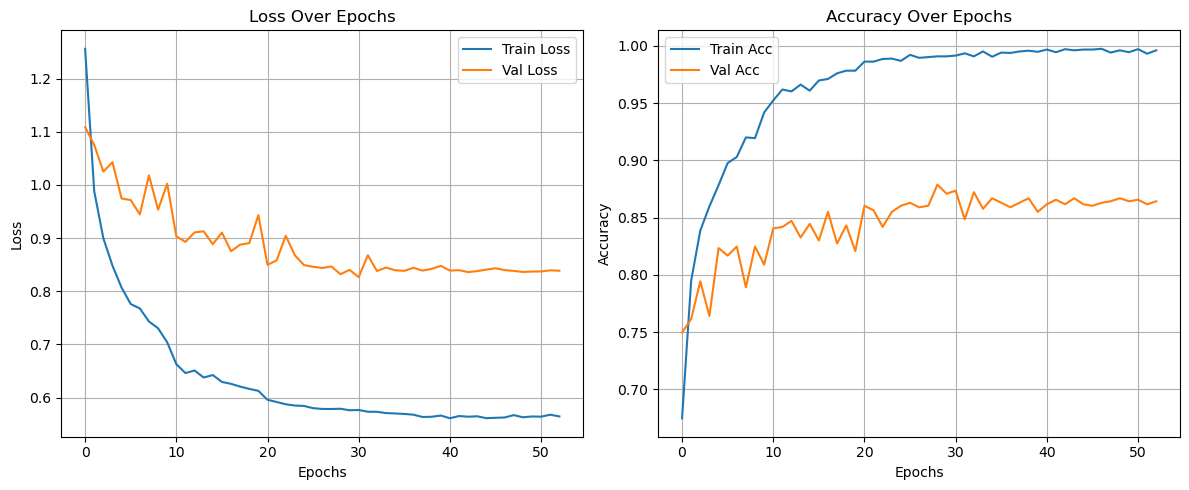


Class-wise Performance:

                       precision    recall  f1-score   support

          1-Cardboard       0.98      1.00      0.99       277
      2-Food Organics       0.99      0.98      0.99       262
              3-Glass       0.99      0.99      0.99       276
              4-Metal       0.97      0.99      0.98       499
5-Miscellaneous Trash       1.00      0.96      0.98       320
              6-Paper       0.96      1.00      0.98       324
            7-Plastic       1.00      0.96      0.98       589
      8-Textile Trash       1.00      0.99      1.00       210
         9-Vegetation       0.96      1.00      0.98       282

             accuracy                           0.98      3039
            macro avg       0.98      0.99      0.98      3039
         weighted avg       0.98      0.98      0.98      3039

Set        | Precision | Recall | F1 Score | AUC
-----------|-----------|--------|----------|------
Train      | 0.984     | 0.986  | 0.985    | 1.000



In [9]:
print("\033[1mTraining RESNET50 model:\033[0m\n")
indices = np.arange(len(X_train))
np.random.seed(42)
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]
val_size = int(0.2 * len(X_train_shuffled))
X_val = X_train_shuffled[:val_size]
y_val = y_train_shuffled[:val_size]
X_train_split = X_train_shuffled[val_size:]
y_train_split = y_train_shuffled[val_size:]
run_transfer_learning_pipeline("resnet50", X_train_split, y_train_split, X_val, y_val, X_test, y_test)


Training RESNET101 model:

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5416 - loss: 1.5567
Epoch 1: val_loss improved from inf to 1.05653, saving model to resnet101_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.5418 - loss: 1.5562 - val_accuracy: 0.7668 - val_loss: 1.0565 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8013 - loss: 0.9910
Epoch 2: val_loss improved from 1.05653 to 1.05171, saving model to resnet101_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.8013 - loss: 0.9910 - val_accuracy: 0.7721 - val_loss: 1.0517 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8366 - loss: 0.9027
Epoch 3: val_loss did not improve from 1.05171
608/608 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.8366 - loss: 0.9027 - val_accuracy: 0.7602 - val_loss: 1.0610 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - acc

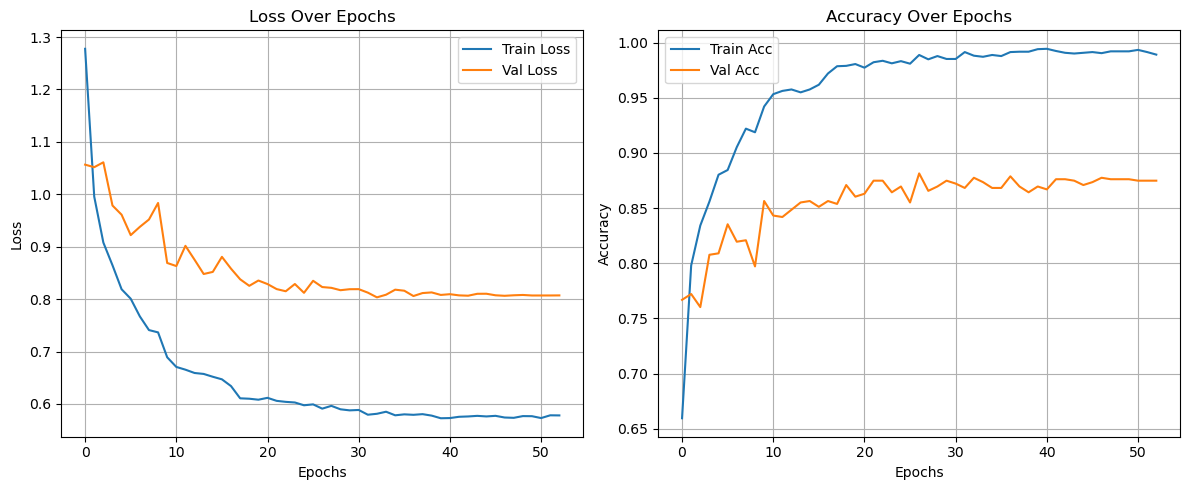


Class-wise Performance:

                       precision    recall  f1-score   support

          1-Cardboard       1.00      0.99      0.99       277
      2-Food Organics       0.99      1.00      0.99       262
              3-Glass       0.99      0.99      0.99       276
              4-Metal       0.98      0.99      0.99       499
5-Miscellaneous Trash       1.00      0.98      0.99       320
              6-Paper       0.99      1.00      0.99       324
            7-Plastic       0.99      0.98      0.98       589
      8-Textile Trash       0.99      1.00      1.00       210
         9-Vegetation       0.99      1.00      0.99       282

             accuracy                           0.99      3039
            macro avg       0.99      0.99      0.99      3039
         weighted avg       0.99      0.99      0.99      3039

Set        | Precision | Recall | F1 Score | AUC
-----------|-----------|--------|----------|------
Train      | 0.990     | 0.992  | 0.991    | 1.000



In [10]:
print("\033[1mTraining RESNET101 model:\033[0m\n")
indices = np.arange(len(X_train))
np.random.seed(42)
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]
val_size = int(0.2 * len(X_train_shuffled))
X_val = X_train_shuffled[:val_size]
y_val = y_train_shuffled[:val_size]
X_train_split = X_train_shuffled[val_size:]
y_train_split = y_train_shuffled[val_size:]
run_transfer_learning_pipeline("resnet101", X_train_split, y_train_split, X_val, y_val, X_test, y_test)
print("\n")

Training VGG16 model:

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4088 - loss: 2.2637
Epoch 1: val_loss improved from inf to 1.25710, saving model to vgg16_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.4090 - loss: 2.2629 - val_accuracy: 0.6838 - val_loss: 1.2571 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6738 - loss: 1.2487
Epoch 2: val_loss improved from 1.25710 to 1.20053, saving model to vgg16_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 47s 77ms/step - accuracy: 0.6738 - loss: 1.2487 - val_accuracy: 0.7404 - val_loss: 1.2005 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7380 - loss: 1.1089
Epoch 3: val_loss improved from 1.20053 to 1.15940, saving model to vgg16_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 47s 77ms/step - accuracy: 0.7380 - loss: 1.1089 - val_accuracy: 0.7391 - val_loss: 1.1594 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━

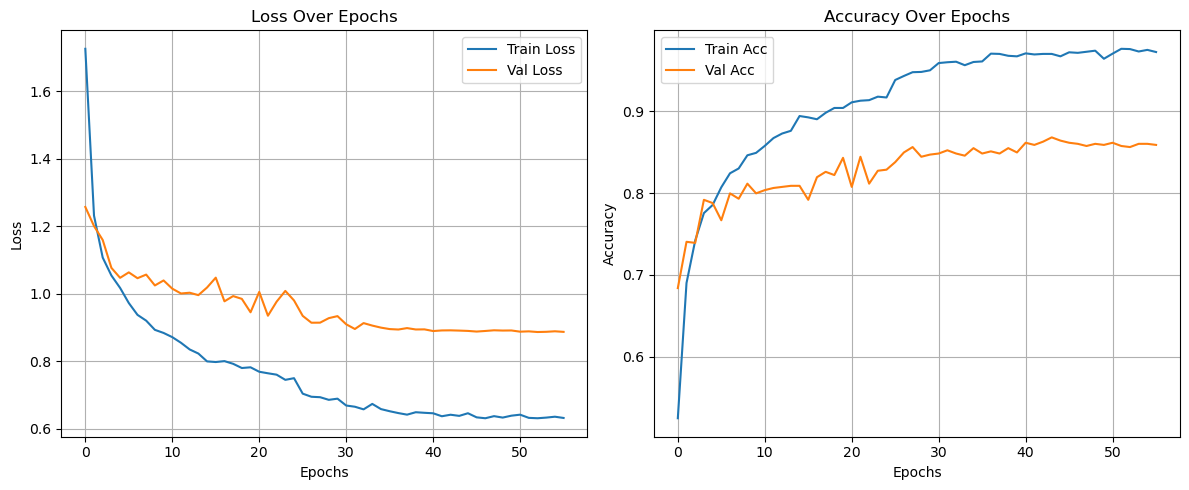


Class-wise Performance:

                       precision    recall  f1-score   support

          1-Cardboard       0.99      0.99      0.99       277
      2-Food Organics       0.98      1.00      0.99       262
              3-Glass       1.00      0.99      0.99       276
              4-Metal       0.99      1.00      1.00       499
5-Miscellaneous Trash       0.99      0.99      0.99       320
              6-Paper       1.00      0.99      1.00       324
            7-Plastic       0.99      0.99      0.99       589
      8-Textile Trash       1.00      1.00      1.00       210
         9-Vegetation       0.99      0.99      0.99       282

             accuracy                           0.99      3039
            macro avg       0.99      0.99      0.99      3039
         weighted avg       0.99      0.99      0.99      3039

Set        | Precision | Recall | F1 Score | AUC
-----------|-----------|--------|----------|------
Train      | 0.994     | 0.993  | 0.993    | 1.000



In [11]:
print("\033[1mTraining VGG16 model:\033[0m\n")
indices = np.arange(len(X_train))
np.random.seed(42)
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]
val_size = int(0.2 * len(X_train_shuffled))
X_val = X_train_shuffled[:val_size]
y_val = y_train_shuffled[:val_size]
X_train_split = X_train_shuffled[val_size:]
y_train_split = y_train_shuffled[val_size:]
run_transfer_learning_pipeline("vgg16", X_train_split, y_train_split, X_val, y_val, X_test, y_test)
print("\n")


Training EFFICIENTNETB0 model:

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6024 - loss: 1.3989
Epoch 1: val_loss improved from inf to 0.94423, saving model to efficientnetb0_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.6026 - loss: 1.3985 - val_accuracy: 0.8248 - val_loss: 0.9442 - learning_rate: 0.0010
Epoch 2/100
607/608 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8226 - loss: 0.9184
Epoch 2: val_loss improved from 0.94423 to 0.93034, saving model to efficientnetb0_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8226 - loss: 0.9184 - val_accuracy: 0.8261 - val_loss: 0.9303 - learning_rate: 0.0010
Epoch 3/100
607/608 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8644 - loss: 0.8333
Epoch 3: val_loss improved from 0.93034 to 0.86427, saving model to efficientnetb0_best.keras
608/608 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8644 - loss: 0.8334 - val_accuracy: 0.8564 - val_loss: 0.8643 - learning_rate: 0.00

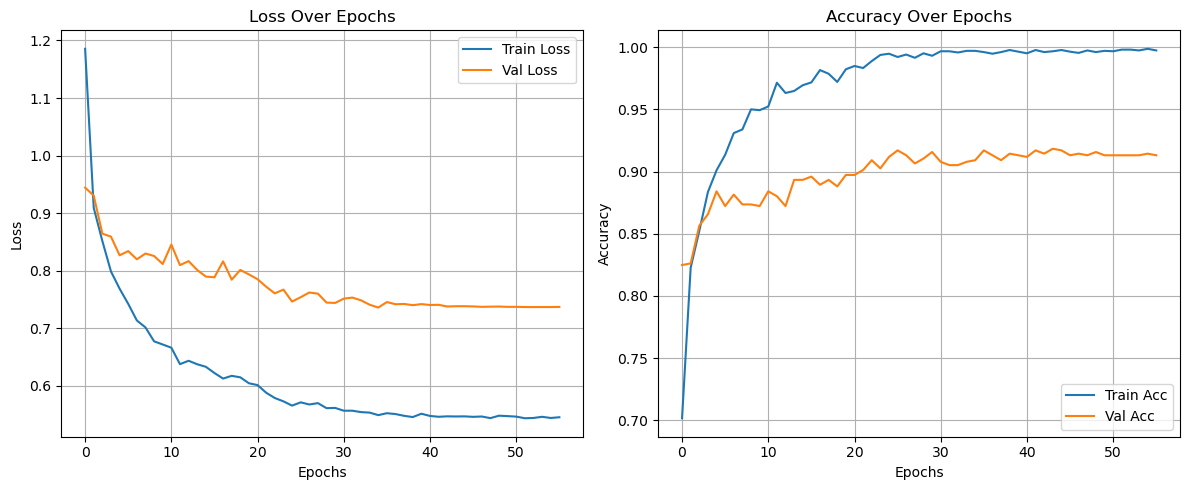


Class-wise Performance:

                       precision    recall  f1-score   support

          1-Cardboard       1.00      1.00      1.00       277
      2-Food Organics       1.00      1.00      1.00       262
              3-Glass       1.00      1.00      1.00       276
              4-Metal       0.99      1.00      1.00       499
5-Miscellaneous Trash       1.00      0.99      1.00       320
              6-Paper       1.00      1.00      1.00       324
            7-Plastic       1.00      1.00      1.00       589
      8-Textile Trash       1.00      1.00      1.00       210
         9-Vegetation       1.00      1.00      1.00       282

             accuracy                           1.00      3039
            macro avg       1.00      1.00      1.00      3039
         weighted avg       1.00      1.00      1.00      3039

Set        | Precision | Recall | F1 Score | AUC
-----------|-----------|--------|----------|------
Train      | 0.999     | 0.999  | 0.999    | 1.000



In [12]:
print("\033[1mTraining EFFICIENTNETB0 model:\033[0m\n")
indices = np.arange(len(X_train))
np.random.seed(42)
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]
val_size = int(0.2 * len(X_train_shuffled))
X_val = X_train_shuffled[:val_size]
y_val = y_train_shuffled[:val_size]
X_train_split = X_train_shuffled[val_size:]
y_train_split = y_train_shuffled[val_size:]
run_transfer_learning_pipeline("efficientnetb0", X_train_split, y_train_split, X_val, y_val, X_test, y_test)
print("\n")

<b><h4>Evaluation Results for All Models</h4></b>

In [13]:
df = pd.DataFrame.from_dict(model_test_results, orient='index')
df.index.name = 'Model'
print("\033[1mSummary of test Results of all models:\033[0m\n")
df

Summary of test Results of all models:



,Precision,Recall,F1 Score,AUC
Model,,,,
resnet50,0.814,0.798,0.801,0.976
resnet101,0.841,0.823,0.829,0.978
vgg16,0.799,0.779,0.785,0.966
efficientnetb0,0.849,0.832,0.833,0.977


In [14]:
df_cv = pd.DataFrame.from_dict(model_cv_results, orient='index')
df_cv.index.name = 'Model'
print("\033[1mSummary of Validation Results of all models:\033[0m\n")
df_cv

Summary of Validation Results of all models:



,Precision,Recall,F1 Score,AUC
Model,,,,
resnet50,0.872,0.874,0.870,0.990
resnet101,0.885,0.885,0.883,0.990
vgg16,0.861,0.857,0.857,0.982
efficientnetb0,0.916,0.912,0.913,0.993


<b><h3>Conclusion:</h3>
<b>ResNet101 clearly outperforms the others across every metric—highest precision.<br>
EfficientNetB0 is a close second, and VGG16 trails behind. So for this multiclass task, ResNet101 is the best choice.</b>

<b>References and Citations</b>
<ul>
    <li>https://chatgpt.com/</li>
    <li>https://scikit-learn.org/stable/user_guide.html</li>
    <li>https://stackoverflow.com/</li>
    <li>https://www.datacamp.com/tutorial/random-forests-classifier-python</li>
    <li>https://www.tensorflow.org/api_docs</li>
    <li>https://keras.io/api/</li>
    <li>https://pandas.pydata.org/docs/</li>
    <li>https://docs.python.org/3/</li>
    <li>https://www.kaggle.com/</li>
</ul>
